# Support Vector Machines

    Notebook version: 1.0 (Oct 28, 2015)
                      1.1 (Oct 27, 2016)
                      
This notebook is a compilation of material taken from several sources:
    
- The <a href = http://scikit-learn.org/stable/modules/svm.html> sklearn documentation </a>
- A <a href = https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/03.1-Classification-SVMs.ipynb > notebook </a> by <a href= https://github.com/jakevdp> Jake Vanderplas</a>
- <a href = https://en.wikipedia.org/wiki/Support_vector_machine> Wikipedia </a>

    Compiled by: Jesús Cid Sueiro (jcid@tsc.uc3m.es)

    Changes: v.1.0 - First version

In [2]:
# To visualize plots in the notebook
%matplotlib inline

# Imported libraries
#import csv
#import random
#import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
#import pylab

import numpy as np
#from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets.samples_generator import make_circles

from ipywidgets import interact

## 1. Introduction

<small> <font color="blue"> [Source: <a href = http://scikit-learn.org/stable/modules/svm.html> sklearn documentation </a>]</font> </small>

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
- Versatile: different Kernel functions can be specified for the decision function.

The disadvantages of support vector machines include:

- SVMs do not directly provide probability estimates.

## 2. Motivating Support Vector Machines

<small> <font color="blue"> [Source: <a href = https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/03.1-Classification-SVMs.ipynb > notebook </a> by <a href= https://github.com/jakevdp> Jake Vanderplas</a>] </font> </small>

Support Vector Machines (SVMs) are a kind of ***discriminative*** classifiers: that is, they draw a boundary between clusters of data without making any explicit assumption about the probability model generating underlying the data generation process.

Let's show a quick example of support vector classification. First we need to create a dataset:

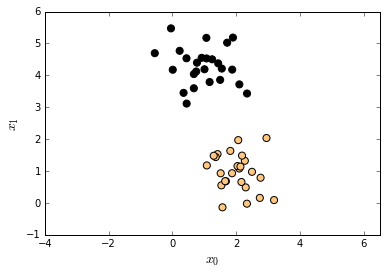

In [3]:
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='copper')
plt.xlabel("$x_0$", fontsize=14)
plt.ylabel("$x_1$", fontsize=14)
plt.axis('equal')
plt.show()

A discriminative classifier attempts to draw a line between the two sets of data. Immediately we see a problem: such a line is ill-posed! For example, we could come up with several possibilities which perfectly discriminate between the classes in this example:

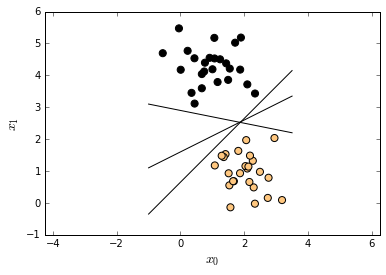

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='copper')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);
plt.xlabel("$x_0$", fontsize=14)
plt.ylabel("$x_1$", fontsize=14)
plt.axis('equal')
plt.show()

These are three very different separators which perfectly discriminate between these samples. Depending on which you choose, a new data point will be classified almost entirely differently! How can we improve on this?

Support Vector Machines (SVM) select the boundary decision maximizing the ***margin***. The margin of a classifier is defined as twice the maximum signed distance between the decision boundary and the training data. By *signed* we mean that the distance to misclassified samples is counted negatively. Thus, if the classification problem is "separable" (i.d. if there exist a decision boundary with zero errors in the training set), the SVM will choose the zero-error decision boundary that is "as far as possible" from the training data.

In summary, what a SVM does is to not only draw a line, but consider the "sample free" region about the line. Here's an example of what it might look like:

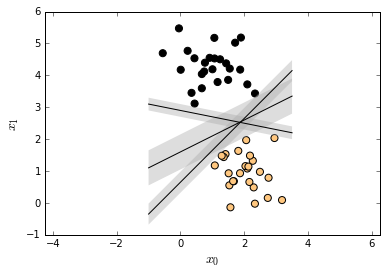

In [6]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='copper')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit-d, yfit+d, edgecolor='none', 
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)
plt.xlabel("$x_0$", fontsize=14)
plt.ylabel("$x_1$", fontsize=14)
plt.axis('equal')
plt.show()

Notice here that if we want to maximize this width, the middle fit is clearly the best. This is the intuition of the SVM, which optimize a linear discriminant model in conjunction with a margin representing the perpendicular distance between the datasets.

## 3. Linear SVM

<small> <font color="blue"> [Source: adapted from <a href = https://en.wikipedia.org/wiki/Support_vector_machine> Wikipedia </a>]</font> </small>

In order to present the SVM in a formal way, consider a training dataset $\mathcal{S} = \left\{ (\mathbf{x}^{(k)}, y^{(k)}) \mid \mathbf{x}^{(k)}\in \Re^N,\, y^{(k)} \in \{-1,1\}, k=1,\ldots, K\right\}$, where the binary symmetric label $y^{(k)}\in \{-1,1\}$ indicates the class to which the point $\mathbf{x}^{(k)}$ belongs. Each $\mathbf{x}^{(k)}$ is a $p$-dimensional real vector. We want to find the maximum-margin hyperplane that divides the points having $y^{(k)}=1$ from those having $y^{(k)}=-1$. 

Any hyperplane can be written as the set of points $\mathbf{x}$ satisfying

$$
\mathbf{w}^\intercal \mathbf{x} - b=0,
$$

where ${\mathbf{w}}$ denotes the (not necessarily normalized) normal vector to the hyperplane. The parameter $\tfrac{b}{\|\mathbf{w}\|}$ determines the offset of the hyperplane from the origin along the normal vector ${\mathbf{w}}$.

If the training data are linearly separable, we can select two parallel hyperplanes in a way that they separate the data and there are no points between them, and then try to maximize their distance. The region bounded by them is called "the margin". These hyperplanes can be described by the equations

$$\mathbf{w}^\intercal \mathbf{x} - b=1$$
and
$$\mathbf{w}^\intercal \mathbf{x} - b=-1.$$

Note that the two equations above can represent any two parallel hyperplanes in $\Re^N$. Essentially, the direction of vector $\mathbf{w}$ determines the orientation of the hyperplanes, whereas parameter $b$ and the norm of $\mathbf{w}$ can be used to select their exact location.

To compute the distance between the hyperplanes, we can obtain the projection of vector ${\mathbf x}_1 - {\mathbf x}_2$, where ${\mathbf x}_1$ and ${\mathbf x}_2$ are points from each of the hyperplanes, onto a unitary vector ortonormal to the hyperplanes:

<img src=./figs/margin_calculation.png width="500">

$$\text{Distance between hyperplanes} = \left[\frac{\mathbf{w}}{\|\mathbf{w}\|}\right]^\intercal ({\mathbf x}_1 - {\mathbf x}_2) = \frac{\mathbf{w}^\intercal {\mathbf x}_1 - \mathbf{w}^\intercal {\mathbf x}_2}{\|\mathbf{w}\|} = \frac{2}{\|\mathbf{w}\|}.$$


Therefore, to maximize the distance between the planes we want to minimize $\|\mathbf{w}\|$.

As we also have to prevent data points from falling into the margin, we add the following constraints: for each $k$ either

\begin{align}
\mathbf{w}^\intercal \mathbf{x}^{(k)} - b &\ge +1, \qquad\text{ if } y^{(k)}=1, \qquad \text{or} \\
\mathbf{w}^\intercal \mathbf{x}^{(k)} - b &\le -1, \qquad\text{ if } y^{(k)}=-1.
\end{align}

This can be rewritten as:

$$
y^{(k)}(\mathbf{w}^\intercal \mathbf{x}^{(k)} - b) \ge 1, \quad \text{ for all } 1 \le k \le K.
$$

We can put this together to get the optimization problem:

$$
(\mathbf{w}^*,b^*) = \arg\min_{(\mathbf{w},b)} \|\mathbf{w}\| \\
\text{subject to: } 
y^{(k)}(\mathbf{w}^\intercal \mathbf{x}^{(k)} - b) \ge 1, \, \text{ for any } k = 1, \dots, K
$$


This optimization problem is difficult to solve because it depends on $\|\mathbf{w}\|$, the norm of $\mathbf{w}$, which involves a square root. Fortunately it is possible to alter the minimization objective $\|\mathbf{w}\|$ by substituting it with $\tfrac{1}{2}\|\mathbf{w}\|^2$ (the factor of $\frac{1}{2}$ being used for mathematical convenience) without changing the solution (the minimum of the original and the modified equation have the same $\mathbf{w}$ and $b$):

$$
(\mathbf{w}^*,b^*) = \arg\min_{(\mathbf{w},b)} \frac{1}{2}\|\mathbf{w}\|^2 \\
\text{subject to: } 
y^{(k)}(\mathbf{w}^\intercal \mathbf{x}^{(k)} - b) \ge 1, \, \text{ for any } k = 1, \dots, K
$$

This is a particular case of a *quadratic programming* problem. 


### 3.1. Primal form

The optimization problem stated in the preceding section can be solved by means of a generalization of the Lagrange method of multipliers for inequality constraints, using the so called Karush–Kuhn–Tucker (KKT) multipliers $\boldsymbol{\alpha}$. According to it, the constrained problem can be expressed as

$$(\mathbf{w}^*,b^*, \boldsymbol{\alpha}^*) = \arg\min_{\mathbf{w},b } \max_{\boldsymbol{\alpha}\geq 0 } \left\{ \frac{1}{2}\|\mathbf{w}\|^2 - \sum_{k=1}^{K}{\alpha^{(k)}[y^{(k)}(\mathbf{w}^\intercal \mathbf{x}^{(k)} - b)-1]} \right\}
$$

that is we look for a *saddle point*.

A key result in convex optimization theory is that, for the kind of optimization problems discussed here (see <a href = http://www.onmyphd.com/?p=kkt.karush.kuhn.tucker&ckattempt=1> here</a>, for instance), the *max* and *min* operators are interchangeable, so that
$$
(\mathbf{w}^*,b^*, \boldsymbol{\alpha}^*) = \arg\max_{\boldsymbol{\alpha}\geq 0 } \min_{\mathbf{w},b } \left\{ \frac{1}{2}\|\mathbf{w}\|^2 - \sum_{k=1}^{K}{\alpha^{(k)}[y^{(k)}(\mathbf{w}^\intercal \mathbf{x}^{(k)} - b)-1]} \right\}
$$

Note that the inner minimization problem is now quadratic in $\mathbf{w}$ and, thus, the minimum can be found by differentiation:
$$
\mathbf{w}^* = \sum_{k=1}^K{\alpha^{(k)} y^{(k)}\mathbf{x}^{(k)}}.
$$


#### 3.1.1. Support Vectors

In view of the optimization problem, we can check that all the points which can be separated as $y^{(k)}(\mathbf{w}^\intercal \mathbf{x}^{(k)} - b) - 1 > 0 $ do not matter since we must set the corresponding $\alpha^{(k)}$ to zero. Therefore, only a few $\alpha^{(k)}$ will be greater than zero. The corresponding $\mathbf{x}^{(k)}$ are known as `support vectors`.

It can be seen that the optimum parameter vector $\mathbf{w}^\ast$ can be expressed in terms of the support vectors only:

$$
\mathbf{w}^* = \sum_{k\in {\cal{S}}_{SV}}{\alpha^{(k)} y^{(k)}\mathbf{x}^{(k)}}.
$$

where ${\cal{S}}_{SV}$ is the set of indexes associated to support vectors.


#### 3.1.2. The computation of $b$

Support vectors lie on the margin and satisfy $y^{(k)}(\mathbf{w}^\intercal \mathbf{x}^{(k)} - b) = 1$. From this condition, we can obtain the value of $b$, since por any support vector:

$$\mathbf{w}^\intercal\mathbf{x}^{(k)} - b = \frac{1}{y^{(k)}} = y^{(k)} \iff b = \mathbf{w}^\intercal\mathbf{x}^{(k)} - y^{(k)}
$$

This estimate of $b$, the centerpoint of the division, depends only on a single pair $y^{(k)}$ and $x^{(k)}$.  We may get a more robust estimate of the center by averaging over all of the $N_{SV}$ support vectors, if we believe the population mean is a good estimate of the midpoint, so in practice, $b$ is often computed as:

$$
b = \frac{1}{N_{SV}} \sum_{k\in {\cal{S}}_{SV}}{(\mathbf{w}^\intercal\mathbf{x}^{(k)} - y^{(k)})}
$$

### 3.2. Dual form

Writing the classification rule in its unconstrained dual form reveals that the *maximum-margin hyperplane* and therefore the classification task is only a function of the ''support vectors'', the subset of the training data that lie on the margin.

Using the fact that $\|\mathbf{w}\|^2 = \mathbf{w}^\intercal \mathbf{w}$ and substituting $\mathbf{w} = \sum_{k=1}^K{\alpha^{(k)} y^{(k)}\mathbf{x}^{(k)}}$, we obtain

\begin{align}
(b^*, \boldsymbol{\alpha}^*) 
   &= \arg\max_{\boldsymbol{\alpha}\geq 0 } 
   \min_b \left\{
   \sum_{k=1}^{K}\alpha^{(k)} - 
   \frac{1}{2}
   \sum_{k=1}^K \sum_{j=1}^K {\alpha^{(k)} \alpha^{(j)} y^{(k)} y^{(j)} (\mathbf{x}^{(k)})^\intercal\mathbf{x}^{(j)}}
   + b \sum_{k=1}^{K}\alpha^{(k)}y^{(k)}
\right\}  
\end{align}

Noting that, if $\sum_{k=1}^{K}\alpha^{(k)}y^{(k)} \neq 0$ the optimal value  of $b$ is $+\infty$ of $-\infty$, and 

\begin{align}
\min_b \left\{
\sum_{k=1}^{K}\alpha^{(k)} - 
\frac{1}{2}
\sum_{k=1}^K \sum_{j=1}^K {\alpha^{(k)} \alpha^{(j)} y^{(k)} y^{(j)} (\mathbf{x}^{(k)})^\intercal\mathbf{x}^{(j)}}
+ b \sum_{k=1}^{K}\alpha^{(k)}y^{(k)}
\right\} = -\infty.
\end{align}

Therefore, any $\boldsymbol{\alpha}$ satifying $\sum_{k=1}^{K}\alpha^{(k)}y^{(k)} \neq 0$ is suboptimal, so that the optimal multipliers must satisfy the condition  $\sum_{k=1}^{K}\alpha^{(k)}y^{(k)} = 0$.


Summarizing, the dual formulation of the optimization problem is

$$
\boldsymbol{\alpha}^* = \arg\max_{\boldsymbol{\alpha}\geq 0} \sum_{k=1}^K \alpha^{(k)} - 
       \frac12 \sum_{k,j} \alpha^{(k)} \alpha^{(j)} y^{(k)} y^{(j)} k(\mathbf{x}^{(k)}, \mathbf{x}^{(j)})  \\
\text{subject to: } \qquad \sum_{k=1}^K \alpha^{(k)} y^{(k)} = 0.
$$

where the *kernel* $k(\cdot)$ is defined by $k(\mathbf{x}^{(k)},\mathbf{x}^{(j)})=(\mathbf{x}^{(k)})^\intercal\mathbf{x}^{(j)}$.

Many implementations of the SVM use this dual formulation. They proceed in three steps:

1. Solve the dual problem to obtain $\boldsymbol{\alpha}^*$. Usually, only a small number of $\alpha^{*(k)}$ are nonzero. The corresponding values of ${\bf x}^{(k)}$ are called the *support vectors*.
2. Compute $\mathbf{w}^* = \sum_{k=1}^K{\alpha^{*(k)} y^{(k)}\mathbf{x}^{(k)}}$
3. Compute $b^* = \frac{1}{N_{SV}} \sum_{\alpha^{*(k)}\neq 0}{(\mathbf{w}^{*\intercal}\mathbf{x}^{(k)} - y^{(k)})}
$


## 4. Fitting a Support Vector Machine

<small> <font color="blue"> [Source: <a href = https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/03.1-Classification-SVMs.ipynb > notebook </a> by <a href= https://github.com/jakevdp> Jake Vanderplas</a>] </font> </small>


Now we'll fit a Support Vector Machine Classifier to these points.


In [8]:
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

/Users/jcid/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/jcid/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/jcid/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

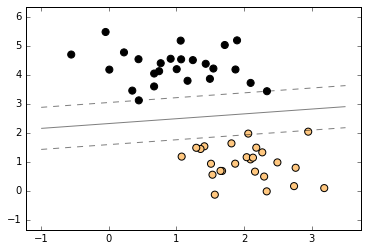

In [9]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='copper')
plot_svc_decision_function(clf);

Notice that the dashed lines touch a couple of the points: these points are the *support vectors*. In scikit-learn, these are stored in the ``support_vectors_`` attribute of the classifier:

/Users/jcid/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/jcid/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/jcid/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

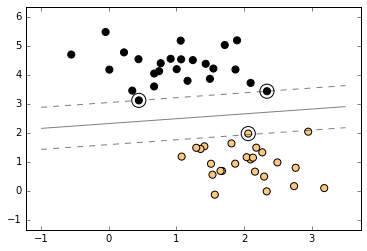

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='copper')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

Let's use IPython's interact functionality to explore how the distribution of points affects the support vectors and the discriminative fit. (This is only available in IPython 2.0+, and will not work in a static view)

<function __main__.plot_svm>

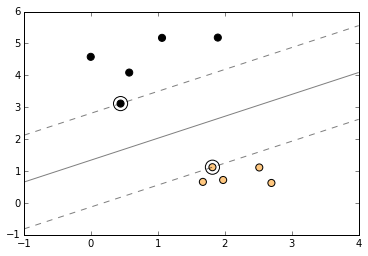

In [7]:
def plot_svm(N=10):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = svm.SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='copper')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 200], kernel='linear')

Notice the unique thing about SVM is that only the support vectors matter: that is, if you moved any of the other points without letting them cross the decision boundaries, they would have no effect on the classification results!

## 5. Non-separable problems.

<small> <font color="blue"> [Source: adapted from <a href = https://en.wikipedia.org/wiki/Support_vector_machine> Wikipedia </a>]</font> </small>

In 1995, Corinna Cortes and Vladimir N. Vapnik suggested a modified maximum margin idea that allows for mislabeled examples. If there exists no hyperplane that can split the `positive` and `negative` samples, the `Soft Margin`
 method will choose a hyperplane that splits the examples as cleanly as possible, while still maximizing the distance to the nearest cleanly split examples. The method introduces non-negative slack variables, $\xi^{(k)}$, which measure the degree of misclassification of the data $\mathbf{x}^{(k)}$

$$y^{(k)}(\mathbf{w}^\intercal\mathbf{x}^{(k)} - b) \ge 1 - \xi^{(k)} \quad 1 \le k \le K.
$$

The objective function is then increased by a function which penalizes non-zero $\xi^{(k)}$, and the optimization becomes a trade off between a large margin and a small error penalty. If the penalty function is linear, the optimization problem becomes:

$$(\mathbf{w}^*,\mathbf{\xi}^*, b^*) = \arg\min_{\mathbf{w},\mathbf{\xi}, b } \left\{\frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{k=1}^K \xi^{(k)} \right\} \\
\text{subject to: } \quad y^{(k)}(\mathbf{w}\cdot\mathbf{x_i} - b) \ge 1 - \xi^{(k)}, \quad \xi^{(k)} \ge 0, \quad  k=1,\ldots, K.
$$



This constraint along with the objective of minimizing $\|\mathbf{w}\|$ can be solved using KKT multipliers as done above. One then has to solve the following problem:

$$
\arg\min_{\mathbf{w}, \mathbf{\xi}, b } \max_{\boldsymbol{\alpha}, \boldsymbol{\beta} }
\left\{ \frac{1}{2}\|\mathbf{w}\|^2 
+ C \sum_{k=1}^K \xi^{(k)}
- \sum_{k=1}^K {\alpha^{(k)}[y^{(k)}(\mathbf{w}^\intercal \mathbf{x}^{(k)} - b) -1 + \xi^{(k)}]}
- \sum_{k=1}^K \beta^{(k)} \xi^{(k)} \right \}\\
\text{subject to: } \quad 
\alpha^{(k)}, \beta^{(k)} \ge 0.
$$

A similar analysis to that in the separable case can be applied to show that the dual formulation of the optimization problem is

$$
        \boldsymbol{\alpha}^* = \arg\max_{0 \leq \alpha^{(k)} \leq C , \, k=1,\ldots,K} \sum_{k=1}^K \alpha^{(k)} - 
       \frac12 \sum_{k,j} \alpha^{(k)} \alpha^{(j)} y^{(k)} y^{(j)} k(\mathbf{x}^{(k)}, \mathbf{x}^{(j)})  \\
\text{subject to: } \qquad \sum_{k=1}^K \alpha^{(k)} y^{(k)} = 0.
$$
Note that the only difference with the separable case is given by the constraints $\alpha^{(k)} \leq C$.

## 6. Nonlinear classification

<small> <font color="blue"> [Source: adapted from <a href = https://en.wikipedia.org/wiki/Support_vector_machine> Wikipedia </a>]</font> </small>

The original optimal hyperplane algorithm proposed by Vapnik in 1963 was a linear classifier. However, in 1992, Bernhard E. Boser, Isabelle M. Guyon and Vladimir N. Vapnik suggested a way to create nonlinear classifiers by applying the *kernel trick* to maximum-margin hyperplanes. The resulting algorithm is formally similar, except that every dot product is replaced by a nonlinear kernel function. This allows the algorithm to fit the maximum-margin hyperplane in a transformed feature space. The transformation may be nonlinear and the transformed space high dimensional; thus though the classifier is a hyperplane in the high-dimensional feature space, it may be nonlinear in the original input space.

<img src=./figs/kernel.png width="500">

The kernel is related to the transform $\phi(\mathbf{x})$ by the equation $k(\mathbf{x}, \mathbf{x}') = \phi(\mathbf{x})^\intercal \phi(\mathbf{x}')$. However, note that we do not need to explicitly compute $\phi(\mathbf{x})$, as long as we can express all necessary calculations in terms of the kernel function only, as it is the case for the optimization problem in the dual case.


The predictions of the SVM classifier can also be expressed in terms of kernels only, so that we never need to explicitely compute $\phi(\mathbf{x})$.

$$\begin{align}\hat y({\mathbf{x}}) & = {\mathbf {w^\ast}}^\intercal {\mathbf{x}} + b^\ast \\ \\
& = \left[\sum_{k \in {\cal{S}}_{SV}} \alpha^{(k)^*} y^{(k)} \phi(\mathbf{x}^{(k)})\right]^\intercal {\mathbf{x}} + b^\ast  \\ \\
& = b^\ast + \sum_{k \in {\cal{S}}_{SV}} \alpha^{(k)^*} y^{(k)} k(\mathbf{x}^{(k)}, {\mathbf{x}})
\end{align}$$


Some common kernels include:

* **Gaussian**: $k(\mathbf{x},\mathbf{x}')=\exp(-\gamma \|\mathbf{x} - \mathbf{x}'\|^2)$, for $\gamma > 0$. Sometimes parametrized using $\gamma=1/{2 \sigma^2}$. This is by far the most widely used kernel.
* Polynomial (homogeneous): $k(\mathbf{x},\mathbf{x}')=(\mathbf{x}^\intercal \mathbf{x}')^d$
* Polynomial (inhomogeneous): $k(\mathbf{x},\mathbf{x}') = (\mathbf{x}^\intercal \mathbf{x}' + 1)^d$
* Hyperbolic tangent: $k(\mathbf{x},\mathbf{x}') = \tanh(\kappa \mathbf{x}^\intercal \mathbf{x}'+c)$, for some (not every) $\kappa > 0$ and $c < 0$.



### 6.1. Example.

<small> <font color="blue"> [Source: <a href = https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/03.1-Classification-SVMs.ipynb > notebook </a> by <a href= https://github.com/jakevdp> Jake Vanderplas</a>] </font> </small>

Where SVM gets incredibly exciting is when it is used in conjunction with *kernels*.
To motivate the need for kernels, let's look at some data which is not linearly separable:

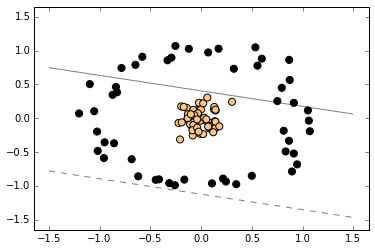

In [9]:
X, y = make_circles(100, factor=.1, noise=.1)

clf = svm.SVC(kernel='linear').fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='copper')
plot_svc_decision_function(clf);

Clearly, no linear discrimination will ever separate these data.
One way we can adjust this is to apply a **kernel**, which is some functional transformation of the input data.

For example, one simple model we could use is a **radial basis function**

In [10]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

If we plot this along with our data, we can see the effect of it:

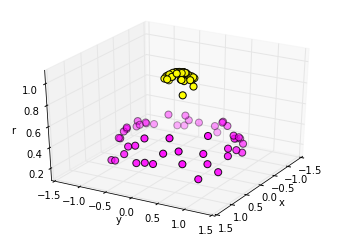

In [11]:
def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

We can see that with this additional dimension, the data becomes trivially linearly separable!
This is a relatively simple kernel; SVM has a more sophisticated version of this kernel built-in to the process. This is accomplished by using the Gaussian kernel (``kernel='rbf'``), short for *radial basis function*:

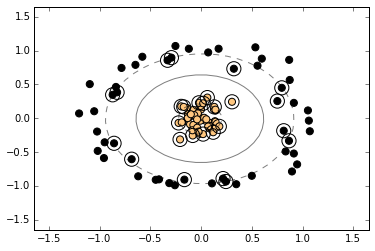

In [12]:
clf = svm.SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='copper')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

Here there are effectively $N$ basis functions: one centered at each point! Through a clever mathematical trick, this computation proceeds very efficiently using the "Kernel Trick", without actually constructing the matrix of kernel evaluations.

** Exercise**: Apply the linear SVM and the SVM with Gaussian kernel to the discrimination of classes `Versicolor` and `Virginica` in the Iris Dataset, using atributes $x_0$ and $x_1$ only. Plot the corresponding decision boundaries, the support vectors. 

## 7. Hyperparameters

Note that the SVM formulation has several free parameters (hyperparameters) that must be selected out of the optimization problem:

- The free parameter $C$ used to solve non-separable problems.
- The kernel parameters (for instance, parameter $\gamma$ from the Gaussian kernel.

These parameters are usually adjusted using a cross-validation procedure.